# 准备数据

titanic数据集的目标是根据乘客信息预测它们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用pandas进行预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明：


Survived:0代表死亡，1代表存活【y标签】

Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】

Name:乘客姓名 【舍去】

Sex:乘客性别 【转换成bool特征】

Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】

SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】

Parch:乘客父母/孩子的个数(整数值)【数值特征】

Ticket:票号(字符串)【舍去】

Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】

Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】

Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）

label的分布情况

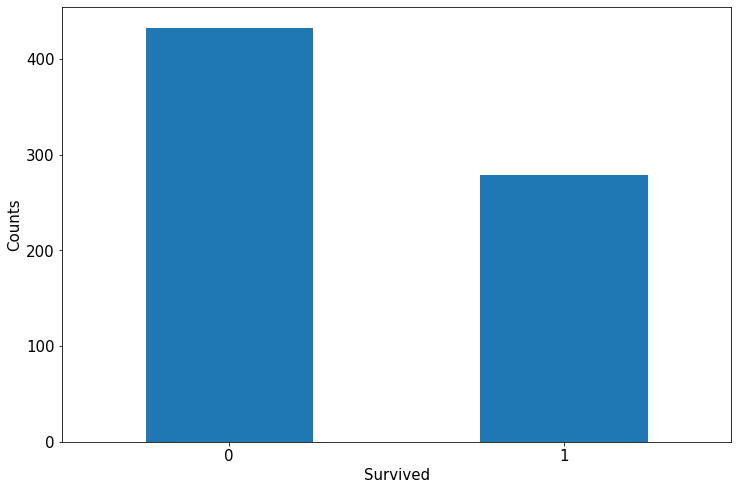

In [15]:
%matplotlib inline
%config InlineBackend.figure_format='png'
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar',figsize=(12,8),fontsize=15,rot=0)
ax.set_ylabel('Counts',fontsize=15)
ax.set_xlabel('Survived',fontsize=15)
plt.show()

年龄分布情况

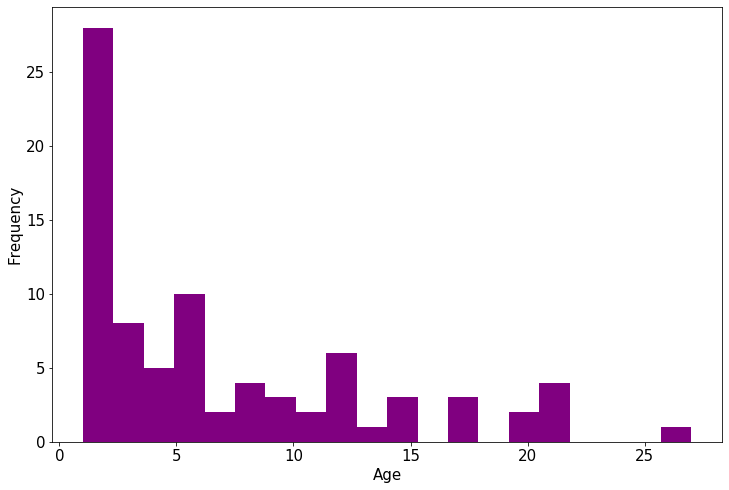

In [20]:
%matplotlib inline
%config InlineBackend.figure_format='png'
ax = dftrain_raw['Age'].value_counts().plot(kind='hist',bins=20,color='purple',figsize=(12,8),fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_xlabel('Age',fontsize=15)
plt.show()

年龄和label的相关性

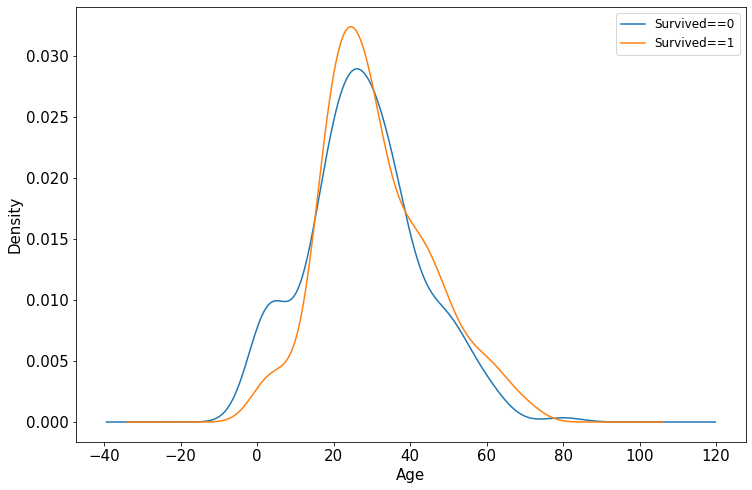

In [23]:
%matplotlib inline
%config InlineBackend.figure_format='png'
ax = dftrain_raw.query('Survived==1')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
dftrain_raw.query('Survived==0')['Age'].plot(kind='density',figsize=(12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize=12)
ax.set_ylabel('Density',fontsize=15)
ax.set_xlabel('Age',fontsize=15)
plt.show()

下面为正式的数据预处理

In [49]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    
    #pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])   #pandas.get_dummies() 实现one hot encoder
    dfPclass.columns = ['Pclass_'+str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult,dfPclass],axis=1)
    
    # sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis=1)
    
    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')
    
    
    #Sibsp,parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    
    
    #Cabin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')
    
    # Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_'+str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis=1)
    
    return (dfresult)
    

x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

print("x_train.shape = ",x_train.shape)
print("x_test.shape = ",x_test.shape)
    

x_train.shape =  (712, 15)
x_test.shape =  (179, 15)


# 定义模型

使用keras有以下三种方式构建模型：Sequential按层顺序构建模型，使用函数式API构建任意结构模型，继承Model基类构建自定义模型

此处使用最简单的Sequental，按层顺序模型

In [50]:
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Dense(20,activation='relu',input_shape=(15,)))
model.add(layers.Dense(10,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


# 训练模型

训练模型通常有三种方法，内置fit方法，内置train_on_batch方法，以及自定义训练循环。此处我们选择最常用也是最简单的内置fit方法。

In [59]:
# 二分类问题选择二元交叉熵损失函数
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=['AUC'])
model.fit(x_train,
          y_train,
         batch_size=64,
         epochs=30,
         validation_split=0.2) # 分割一部分训练数据用于验证

Train on 569 samples, validate on 143 samples
Epoch 1/30
569/569 [==============================] - 0s 705us/sample - loss: 0.5209 - auc_2: 0.8171 - val_loss: 0.5644 - val_auc_2: 0.7619
Epoch 2/30
569/569 [==============================] - 0s 69us/sample - loss: 0.5070 - auc_2: 0.8273 - val_loss: 0.5676 - val_auc_2: 0.7600
Epoch 3/30
569/569 [==============================] - 0s 70us/sample - loss: 0.4991 - auc_2: 0.8400 - val_loss: 0.5614 - val_auc_2: 0.7648
Epoch 4/30
569/569 [==============================] - 0s 76us/sample - loss: 0.5016 - auc_2: 0.8306 - val_loss: 0.5688 - val_auc_2: 0.7637
Epoch 5/30
569/569 [==============================] - 0s 79us/sample - loss: 0.4908 - auc_2: 0.8479 - val_loss: 0.5669 - val_auc_2: 0.7590
Epoch 6/30
569/569 [==============================] - 0s 76us/sample - loss: 0.4935 - auc_2: 0.8391 - val_loss: 0.5627 - val_auc_2: 0.7729
Epoch 7/30
569/569 [==============================] - 0s 78us/sample - loss: 0.4776 - auc_2: 0.8551 - val_loss: 0.5594 

# 评估模型

我们首先评估一下模型在验证集和训练集上的效果

In [54]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

import matplotlib.pyplot as plt

def plot_metric(history,metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1,len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
    

In [55]:
plot_metric(history,"loss")

NameError: name 'history' is not defined

In [56]:
plot_metric(history,"AUC")

NameError: name 'history' is not defined

我们再来看看模型在测试集上的效果

In [60]:
model.evaluate(x=x_test,y=y_test)

179/179 [==============================] - 0s 83us/sample - loss: 0.4365 - auc_2: 0.8591


[0.43654947290873397, 0.8590586]

# 使用模型

In [62]:
# 预测概率
model.predict(x_test[0:10])

array([[0.19073525],
       [0.60484093],
       [0.50150156],
       [0.96556294],
       [0.65023243],
       [0.8178035 ],
       [0.06206933],
       [0.91635346],
       [0.6099319 ],
       [0.09808149]], dtype=float32)

In [63]:
# 预测类别
model.predict_classes(x_test[0:10])

array([[0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0]])

# 保存模型

可以使用Keras方式保存模型，也可以使用tensorflow原生方式保存模型。前者仅仅适合python环境恢复模型，后者则可以跨平台进行模型部署

推荐使用后一种方式

## 1.Keras方式保存

In [66]:
# 保存模型结构及权重
model.save('./data/keras_model.h5')

# 删除现有模型
del model

#加载模型
model = models.load_model('./data/keras_model.h5')
model.evaluate(x_test,y_test)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
179/179 [==============================] - 0s 702us/sample - loss: 0.4365 - auc_4: 0.8591


[0.43654947290873397, 0.8590586]

In [68]:
# 保存模型结构
json_str = model.to_json()
print(json_str)

# 恢复模型结构
model_json = models.model_from_json(json_str)
print(model_json)

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "Dense", "config": {"name": "dense", "trainable": true, "batch_input_shape": [null, 15], "dtype": "float32", "units": 20, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "dtype": "float32", "units": 10, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null,

In [70]:
# 保存模型权重
model.save_weights('./data/keras_model_weight.h5')

# 恢复模型结构
model_json = models.model_from_json(json_str)
model_json.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=['AUC'])

# 加载权重
model_json.load_weights('./data/keras_model_weight.h5')
model_json.evaluate(x_test,y_test)

179/179 [==============================] - 0s 692us/sample - loss: 0.4365 - auc_6: 0.8591


[0.43654947290873397, 0.8590586]

## 2.Tensorflow原生保存方式

In [75]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights('./data/tf_model_weights.ckpt',save_format='tf')

In [78]:
# 保存模型结构和模型参数到文件，该方式保存的模型具有跨平台性便于部署

model.save('./data/tf_model_savedmodel', save_format="h5")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./data/tf_model_savedmodel')
model_loaded.evaluate(x_test,y_test)

export saved model.
179/179 [==============================] - 0s 749us/sample - loss: 0.4365 - auc_8: 0.8591


[0.43654947290873397, 0.8590586]